# Model Training

## Outline of Model Use

Quick definitions:
1. Capital Loss = results from a trade in which we purchase a stock and it goes down in value


2. Opportunity Cost = results from not placing a trade that turns out to be profitable


3. False Positive = labeling a stock a buy that is not in fact a buy (resulting in capital loss)


4. False Negative = labeling a stock a not_but that is in fact a buy (resulting in opportunity cost)



Thesis: Goal is to limit capital losses (i.e., chase models that limit false positives, which results in using a model with the highest precision score) and opportunity cost (i.e., chase models that limit false negatives, which results in using a model with the highest recall score).

## Import packages and Dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from IPython.display import Image  
from pydotplus import graph_from_dot_data
import nbimporter
from helper import *
%run helper.ipynb
import itertools

Importing Jupyter notebook from helper.ipynb


In [70]:
df = pd.read_csv('final_fundamental_data.csv')

print(df.shape)
df.head(10)

(2033, 15)


ticker                     company_name  52_week_delta  \
0    PIH  1347 Property Insurance Holding      -0.206614   
1   FLWS          1-800 FLOWERS.COM, Inc.       6.179774   
2   SRCE           1st Source Corporation      12.263334   
3   TWOU                         2U, Inc.     -60.269946   
4    DDD           3D Systems Corporation     -25.217390   
5    MMM                       3M Company     -14.365673   
6   EGHT                          8x8 Inc      -4.809201   
7    AHC       A.H. Belo Corporation (TX)     -28.915662   
8    AOS           A.O. Smith Corporation       5.608559   
9   ATEN               A10 Networks, Inc.      -3.605014   

   dividend_payout_ratio  forward_eps  g_revenue  price_to_forward_earnings  \
0               0.000000         1.15       74.9                      4.261   
1               0.000000         0.68       10.5                     19.059   
2              29.860002         3.55        9.7                     14.411   
3               0.000000        -1.09       43.8                    -20.679   
4               0.000000         0.09       -5.6                     95.389   
5              67.380000         9.69       -2.0                     17.294   
6               0.000000        -0.26       27.8                    -68.462   
7              54.240000         0.45       -6.7                      6.489   
8              36.670000         2.53       -3.4                     17.897   
9               0.000000         0.17      -12.7                     37.353   

   price_to_book  debt_to_equity  return_on_assets  return_on_equity  \
0       0.772505           0.000          0.078000          2.515000   
1       2.539682          52.765          4.989000         11.756000   
2       1.604869           0.000          1.409000         11.557999   
3       1.949153          42.584         -7.259000        -26.075000   
4       1.958257          19.777         -4.547000        -12.539000   
5       9.004353         189.511         10.052000         47.079000   
6       7.438362         126.820        -15.609999        -53.153000   
7       0.778667          31.485         -2.322000         15.215999   
8       4.459326          22.401         10.481000         23.737000   
9       4.770849           4.296         -5.398000        -19.358999   

   gross_margin  ebitda_margin  log_mktcap  analyst_rating  
0     27.115000          0.544   17.199803               0  
1     42.145002          6.150   19.962219               1  
2      0.000000          0.000   20.989492               0  
3     73.874000        -11.690   21.081478               0  
4     44.765000         -0.901   20.739773               0  
5     48.029000         24.773   25.291430               0  
6     60.261000        -27.100   21.302137               1  
7      2.263000          2.263   17.831223               0  
8     40.032002         19.242   22.548788               1  
9     77.000000         -4.811   20.005411               0

## Drop unneeded columns and create dummies

In [71]:
df.drop(['ticker', 'company_name'], axis=1, inplace=True)

In [73]:
# inst_dummies = pd.get_dummies(df['largest_institutional_owner'], drop_first=True)

# df.drop('largest_institutional_owner', axis=1, inplace=True)
# df = pd.concat([df, inst_dummies], axis=1)

# df.head()

## Split X (features) and y (target variable)

In [74]:
X = df.drop(['analyst_rating'], axis=1)
y = df['analyst_rating']
feature_cols = X.columns

In [86]:
feature_cols

Index(['52_week_delta', 'dividend_payout_ratio', 'forward_eps', 'g_revenue',
       'price_to_forward_earnings', 'price_to_book', 'debt_to_equity',
       'return_on_assets', 'return_on_equity', 'gross_margin', 'ebitda_margin',
       'log_mktcap'],
      dtype='object')

## Baseline Model - Dummy Classifier

In [75]:
# train, test, split
base_X_train, base_X_test, base_y_train, base_y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# instantiate classifier, fit model, make predict
base = DummyClassifier()
base.fit(base_X_train, base_y_train)
base_y_pred = base.predict(base_X_test)

# calculate the mean cross validation training and test score
mean_base_cv_train_score = np.mean(cross_val_score(base, base_X_train, base_y_train, cv=3))
mean_base_cv_test_score = np.mean(cross_val_score(base, base_X_test, base_y_test, cv=3))

------------------------------------------------------
Baseline Model Mean Cross Validation Scores
------------------------------------------------------
 Mean CV Training Score:  50.81%
 Mean CV Testing Score:  50.99%

------------------------------------------------------
Baseline Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.40      0.40      0.40       235
           1       0.63      0.63      0.63       375

    accuracy                           0.54       610
   macro avg       0.52      0.52      0.52       610
weighted avg       0.54      0.54      0.54       610

------------------------------------------------------
Baseline Confusion Matrix
------------------------------------------------------


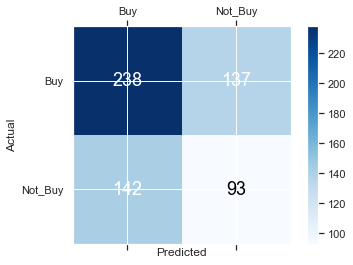

In [76]:
# print mean cross validation scores
print('--'*27)
print('Baseline Model Mean Cross Validation Scores')
print('--'*27)
print(f' Mean CV Training Score: {mean_base_cv_train_score : 0.2%}')
print(f' Mean CV Testing Score: {mean_base_cv_test_score : 0.2%}')
print('')

# print classification report
print('--'*27)
print('Baseline Model Classification Report')
print('--'*27)
print(metrics.classification_report(base_y_test, base_y_pred))

# confusion matrix
print('--'*27)
print('Baseline Confusion Matrix')
print('--'*27)
base_cm = confusion_matrix(base_y_test, base_y_pred, labels=[1,0])
base_classes = ['Buy', 'Not_Buy']
plot_confusion_matrix(base_cm, base_classes)

## Logistic Regression (Log Reg)

In [77]:
# train, test, split
log_X_train, log_X_test, log_y_train, log_y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# instantiate classifier, fit model, make predict
logreg = LogisticRegression()
logreg.fit(log_X_train, log_y_train)
log_y_pred = logreg.predict(log_X_test)

# calculate the mean cross validation training and test score
mean_logreg_cv_train_score = np.mean(cross_val_score(logreg, log_X_train, log_y_train, cv=3))
mean_logreg_cv_test_score = np.mean(cross_val_score(logreg, log_X_test, log_y_test, cv=3))

------------------------------------------------------
Log Reg Model Mean Cross Validation Scores
------------------------------------------------------
 Mean CV Training Score:  60.79%
 Mean CV Testing Score:  65.90%

------------------------------------------------------
Log Reg Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.32      0.43       235
           1       0.68      0.89      0.77       375

    accuracy                           0.67       610
   macro avg       0.66      0.61      0.60       610
weighted avg       0.67      0.67      0.64       610

------------------------------------------------------
Log Reg Confusion Matrix
------------------------------------------------------


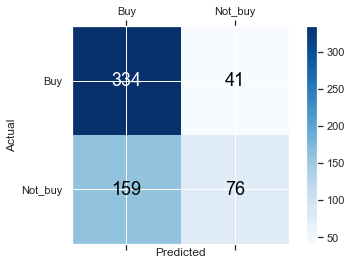

In [78]:
# print mean cross validation scores
print('--'*27)
print('Log Reg Model Mean Cross Validation Scores')
print('--'*27)
print(f' Mean CV Training Score: {mean_logreg_cv_train_score : 0.2%}')
print(f' Mean CV Testing Score: {mean_logreg_cv_test_score : 0.2%}')
print('')

# print classification report
print('--'*27)
print('Log Reg Model Classification Report')
print('--'*27)
print(metrics.classification_report(log_y_test, log_y_pred))

# confusion matrix
print('--'*27)
print('Log Reg Confusion Matrix')
print('--'*27)
log_cm = confusion_matrix(log_y_test, log_y_pred, labels=[1,0])
log_classes = ['Buy', 'Not_buy']
plot_confusion_matrix(log_cm, log_classes)

### Print Log Reg Model

In [95]:
dictionary = dict(zip(list(log_X_train.columns), list(logreg.coef_[0])))

print('Logistic Regression Model:')
print('--'*27)
print(f'Intercept: {logreg.intercept_[0] : 0.3}\n')
print(f'Coefficients: ')
coefficients = list(dictionary.values())
for i, coefficient in enumerate(dictionary):
    print(f'  {coefficient} : {list(dictionary.values())[i] : 0.3}')

Logistic Regression Model:
------------------------------------------------------
Intercept: -2.67

Coefficients: 
  52_week_delta :  0.00439
  dividend_payout_ratio : -0.00903
  forward_eps : -0.00174
  g_revenue :  0.006
  price_to_forward_earnings : -0.000409
  price_to_book :  0.0323
  debt_to_equity :  0.00159
  return_on_assets : -0.0152
  return_on_equity :  0.000688
  gross_margin :  0.00301
  ebitda_margin : -0.00294
  log_mktcap :  0.135


## K Nearest Neighbors (KNN)

In [96]:
# train, test, split
knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# find the optimal k
best_k = 0
best_score = 0
neighbors = range(1,10,2) # will consider min_k = 1, max_k = 25, only odds in between
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k) # instantiate classifier
    knn.fit(knn_X_train, knn_y_train) # fit model
    knn_y_pred = knn.predict(knn_X_test) # make a prediction
    
    # we will consider the optimal K to be the K that produces the highest precision score 
    f1 = metrics.f1_score(knn_y_test, knn_y_pred) 
    if f1 > best_score:
        best_k = k
        best_score = f1

# run the classifier with the optimal K        
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(knn_X_train, knn_y_train)
best_knn_pred = knn.predict(knn_X_test)

# calculate the mean cross validation training and test score
mean_knn_cv_train_score = np.mean(cross_val_score(knn, knn_X_train, knn_y_train, cv=3))
mean_knn_cv_test_score = np.mean(cross_val_score(knn, knn_X_test, knn_y_test, cv=3))

------------------------------------------------------
KNN Model Mean Cross Validation Scores
------------------------------------------------------
 Mean CV Training Score:  62.19%
 Mean CV Testing Score:  60.82%

------------------------------------------------------
KNN Model Classification Report, Optimal K = 7
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.52      0.40      0.45       235
           1       0.67      0.77      0.71       375

    accuracy                           0.62       610
   macro avg       0.59      0.58      0.58       610
weighted avg       0.61      0.62      0.61       610


------------------------------------------------------
KNN Confusion Matrix
------------------------------------------------------


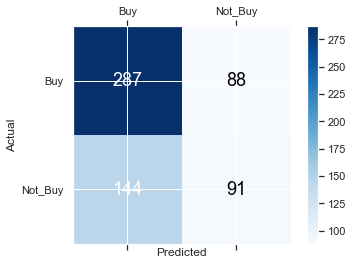

In [97]:
# print mean cross validation scores
print('--'*27)
print('KNN Model Mean Cross Validation Scores')
print('--'*27)
print(f' Mean CV Training Score: {mean_knn_cv_train_score : 0.2%}')
print(f' Mean CV Testing Score: {mean_knn_cv_test_score : 0.2%}')
print('')

# print classification report
print('--'*27)
print(f'KNN Model Classification Report, Optimal K = {best_k}')
print('--'*27)
print(metrics.classification_report(knn_y_test, best_knn_pred))
print('')

# confusion matrix
print('--'*27)
print('KNN Confusion Matrix')
print('--'*27)
knn_cm = confusion_matrix(knn_y_test, knn_y_pred, labels=[1,0])
knn_classes = ['Buy', 'Not_Buy']
plot_confusion_matrix(knn_cm, knn_classes)

### Examine the ROC curve for the model

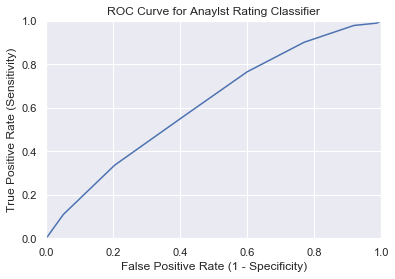

In [99]:
# store the predicted probabilities for class 1
knn_y_pred_prob = knn.predict_proba(knn_X_test)[:, 1]

# plot the ROC cure
plot_ROC_curve(knn_y_test, knn_y_pred_prob)

## Decision Tree Model (DTM)

In [82]:
# train, test, split
dtm_X_train, dtm_X_test, dtm_y_train, dtm_y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# instantiate the classifier
dtm = DecisionTreeClassifier(random_state=42)
dtm.fit(dtm_X_train, dtm_y_train)

# calculate the mean cross validation training and test score
mean_dtm_cv_train_score = np.mean(cross_val_score(dtm, dtm_X_train, dtm_y_train, cv=3))
mean_dtm_cv_test_score = np.mean(cross_val_score(dtm, dtm_X_test, dtm_y_test, cv=3))

In [83]:
# create DOT data
dot_data = export_graphviz(dtm, out_file=None, feature_names=dtm_X_train.columns,
                       class_names=np.unique(y).astype('str'), filled=True,
                       rounded=True, special_characters=True)

# draw graph
graph = graph_from_dot_data(dot_data)

# show graph
Image(graph.create_png())

### Use GridSearchCV to improve results

In [84]:
# create param grid for GridSearch
dtm_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

# instantiate GridSearchCV
dtm_grid_search = GridSearchCV(dtm, dtm_param_grid, cv=3, return_train_score=True)
dtm_grid_search.fit(dtm_X_train, dtm_y_train)
dtm_y_pred = dtm_grid_search.predict(dtm_X_test)

# calculate optimized mean training and testing scores
mean_Odtm_cv_train_score = np.mean(cross_val_score(dtm_grid_search, dtm_X_train, dtm_y_train, cv=3))
mean_Odtm_cv_test_score = np.mean(cross_val_score(dtm_grid_search, dtm_X_test, dtm_y_test, cv=3))

/Users/JacquesPierre/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/JacquesPierre/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/JacquesPierre/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


------------------------------------------------------
DTM Unoptimized Mean Cross Validation Scores
------------------------------------------------------
 Mean CV Training Score:  57.77%
 Mean CV Testing Score:  63.94%

------------------------------------------------------
DTM Optimal Parameters
------------------------------------------------------
 Criterion : gini
 Max_Depth : 3
 Min_Samples_Leaf : 1
 Min_Samples_Split : 2
 Mean CV Training Score:  62.33%
 Mean CV Testing Score:  62.45%

------------------------------------------------------
DTM Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.49      0.29      0.36       235
           1       0.64      0.81      0.72       375

    accuracy                           0.61       610
   macro avg       0.57      0.55      0.54       610
weighted avg       0.58      0.61      0.58       610

---------------------------------------

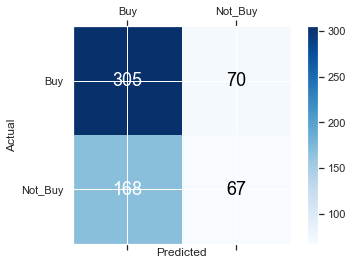

In [85]:
# print mean training score
print('--'*27)
print('DTM Unoptimized Mean Cross Validation Scores')
print('--'*27)
print(f' Mean CV Training Score: {mean_dtm_cv_train_score : 0.2%}')
print(f' Mean CV Testing Score: {mean_dtm_cv_test_score : 0.2%}')
print('')

# print optimal paramas
print('--'*27)
print('DTM Optimal Parameters')
print('--'*27)
dtm_best_params = dtm_grid_search.best_params_
for i, param in enumerate(dtm_best_params):
    print(f' {param.title()} : {list(dtm_best_params.values())[i]}')

print(f' Mean CV Training Score: {mean_Odtm_cv_train_score : 0.2%}')
print(f' Mean CV Testing Score: {mean_Odtm_cv_test_score : 0.2%}')
print('')

# print classification report
print('--'*27)
print('DTM Classification Report')
print('--'*27)
print(metrics.classification_report(dtm_y_test, dtm_y_pred))

# confusion matrix
print('--'*27)
print('DTM Confusion Matrix')
print('--'*27)
dtm_cm = confusion_matrix(dtm_y_test, dtm_y_pred, labels=[1,0])
dtm_classes = ['Buy', 'Not_Buy']
plot_confusion_matrix(dtm_cm, dtm_classes)

### Examine the Feature Importances and ROC curve

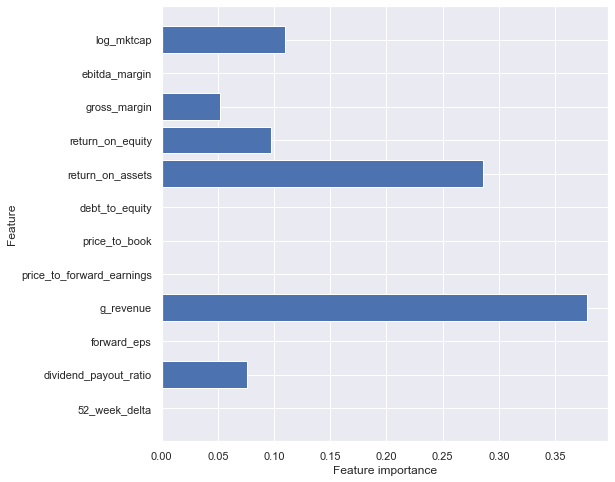

In [87]:
# feature importance
optimized_dtm = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=1, min_samples_split=2)
optimized_dtm.fit(dtm_X_train, dtm_y_train)

n_features = dtm_X_train.shape[1]
plot_feature_importances(dtm_X_train, optimized_dtm_clf, n_features)

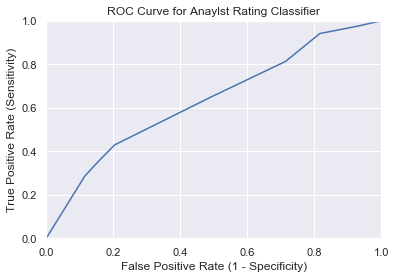

In [88]:
# store the predicted probabilities for class 1
dtm_y_pred_prob = dtm_grid_search.predict_proba(dtm_X_test)[:, 1]

# plot the ROC curve
plot_ROC_curve(dtm_y_test, dtm_y_pred_prob)

## Random Forest Model (RF)

In [89]:
# train, test, split
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# instantiate the classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(rf_X_train, rf_y_train)

# calculate and print the mean cross validation training score
mean_rf_cv_train_score = np.mean(cross_val_score(rf, rf_X_train, rf_y_train, cv=3))
mean_rf_cv_test_score = np.mean(cross_val_score(rf, rf_X_test, rf_y_test, cv=3))

In [90]:
# create param grid for GridSearch
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

# instantiate GridSearchCV
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=3, return_train_score=True)

In [91]:
# fit model and make prediction
rf_grid_search.fit(rf_X_train, rf_y_train)
rf_y_pred = rf_grid_search.predict(rf_X_test)

# calculate optimized mean training and testing scores
mean_Orf_cv_train_score = np.mean(cross_val_score(rf_grid_search, rf_X_train, rf_y_train, cv=3))
mean_Orf_cv_test_score = np.mean(cross_val_score(rf_grid_search, rf_X_test, rf_y_test, cv=3))

/Users/JacquesPierre/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/JacquesPierre/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


------------------------------------------------------
RF Unoptimized Mean Cross Validation Scores
------------------------------------------------------
 Mean CV Training Score:  62.05%
 Mean CV Testing Score:  65.91%

------------------------------------------------------
RF Optimal Parameters
------------------------------------------------------
 Criterion : gini
 Max_Depth : 10
 Min_Samples_Leaf : 6
 Min_Samples_Split : 5
 N_Estimators : 30
 Mean CV Training Score:  65.00%
 Mean CV Testing Score:  68.53%

------------------------------------------------------
RF Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.40      0.48       235
           1       0.69      0.83      0.75       375

    accuracy                           0.67       610
   macro avg       0.65      0.62      0.62       610
weighted avg       0.66      0.67      0.65       610

----------------------

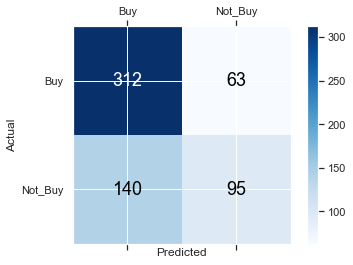

In [92]:
# print mean training score
print('--'*27)
print('RF Unoptimized Mean Cross Validation Scores')
print('--'*27)
print(f' Mean CV Training Score: {mean_rf_cv_train_score : 0.2%}')
print(f' Mean CV Testing Score: {mean_rf_cv_test_score : 0.2%}')
print('')

# print optimal paramas
print('--'*27)
print('RF Optimal Parameters')
print('--'*27)
rf_best_params = rf_grid_search.best_params_
for i, param in enumerate(rf_best_params):
    print(f' {param.title()} : {list(rf_best_params.values())[i]}')

print(f' Mean CV Training Score: {mean_Orf_cv_train_score : 0.2%}')
print(f' Mean CV Testing Score: {mean_Orf_cv_test_score : 0.2%}')
print('')

# print classification report
print('--'*27)
print('RF Classification Report')
print('--'*27)
print(metrics.classification_report(rf_y_test, rf_y_pred))

# confusion matrix
print('--'*27)
print('RF Confusion Matrix')
print('--'*27)
rf_cm = confusion_matrix(rf_y_test, rf_y_pred, labels=[1,0])
rf_classes = ['Buy', 'Not_Buy']
plot_confusion_matrix(rf_cm, rf_classes)

### Examine the Feature Importances and ROC curve

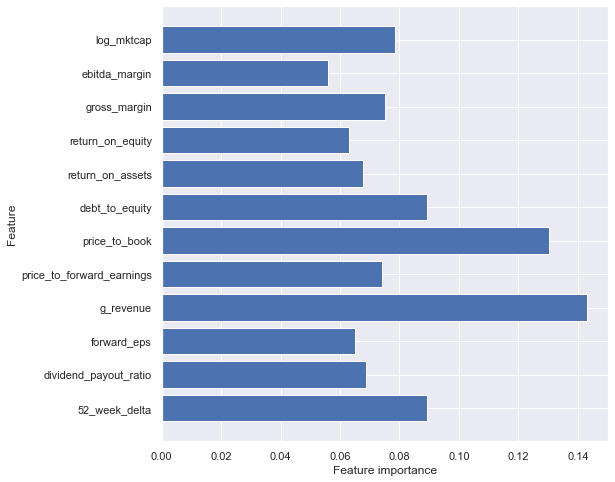

In [107]:
# feature importance
optimized_rf = RandomForestClassifier(criterion='gini', max_depth=10, min_samples_leaf=6, min_samples_split=5, n_estimators=30)
optimized_rf.fit(rf_X_train, rf_y_train)

n_features = rf_X_train.shape[1]
plot_feature_importances(rf_X_train, optimized_rf, n_features)

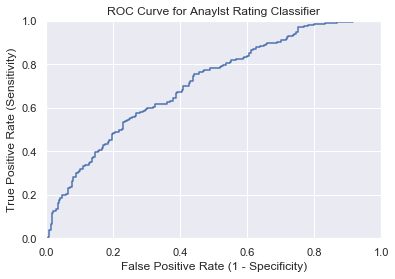

In [108]:
# ROC curve
rf_y_pred_prob = rf_grid_search.predict_proba(rf_X_test)[:, 1]

plot_ROC_curve(rf_y_test, rf_y_pred_prob)

## AdaBoost (ABC)

In [109]:
# train, test, split
abc_X_train, abc_X_test, abc_y_train, abc_y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [110]:
# fit model and make prediction
abc = AdaBoostClassifier(random_state=42)
abc.fit(abc_X_train, abc_y_train)
abc_y_pred = abc.predict(abc_X_test)


# calculate optimized mean training and testing scores
mean_Oabc_cv_train_score = np.mean(cross_val_score(abc, abc_X_train, abc_y_train, cv=3))
mean_Oabc_cv_test_score = np.mean(cross_val_score(abc, abc_X_test, abc_y_test, cv=3))

In [115]:
param_grid = {'n_estimators': [1, 2, 5, 10],
              'learning_rate': [0.1, 0.2, 0.5, 1]
             }

abc_grid_search = GridSearchCV(abc, param_grid=param_grid, scoring='roc_auc')
abc_grid_search.fit(abc_X_train, abc_y_train)
abc_y_pred = abc_grid_search(abc_X_test)

TypeError: 'GridSearchCV' object is not callable